# 3 端到端模型执行
## 3.1 前言
什么是可能的张量函数抽象表达形式？\
什么是可能的张量函数变换？

## 3.2 Demo

In [2]:
from __future__ import annotations
import IPython
import tvm
import numpy as np
from tvm.script import tir as T
from tvm.script import  relax as R
from tvm.ir.module import IRModule
from tvm import relax

In [3]:
# 加载数据集
import torch
import torchvision
test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=False,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

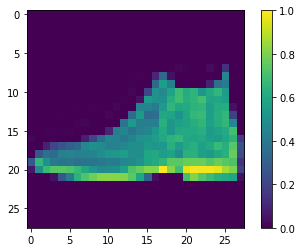

Class: Ankle boot


In [4]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()
print("Class:", class_names[label[0]])

In [5]:
# ckpt
# Hide outputs
# !wget https://github.com/mlc-ai/web-data/raw/main/models/fasionmnist_mlp_params.pkl

## 3.3 端到端模型整合

In [6]:
# Linear -> relu -> Linear
# numpy version
def numpy_mlp(data, w0, b0, w1, b1):
    # print(data.shape, w0.shape)
    lv0 = data @ w0.T + b0
    lv1 = np.maximum(lv0, 0)
    lv2 = lv1 @ w1.T + b1
    return lv2

In [7]:
import pickle as pkl
mlp_params = pkl.load(open("/staff/qiaoliang/ACSA科研项目/tvm_learning/mlc/fasionmnist_mlp_params.pkl", "rb"))

res = numpy_mlp(img.reshape(1, 784),
                mlp_params["w0"],
                mlp_params["b0"],
                mlp_params["w1"],
                mlp_params["b1"])

print(res)
pred_kind = res.argmax(axis=1)
print(pred_kind)
print("numpy mlp prediction:", class_names[pred_kind[0]])

[[-28.304363   -35.1353     -20.574154   -20.60154    -17.119598
    2.7829077  -15.253116     0.21253912  -4.941823     8.811271  ]]
[9]
numpy mlp prediction: Ankle boot


In [8]:
# low level numpy version
def lnumpy_linear0(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y = np.empty((1, 128), 'float32')
    for i in range(1):
        for j in range(128):
            for k in range(784):
                if k == 0 :
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]
    
    for i in range(1):
        for j in range(128):
            Z[i, j] = Y[i, j] + B[j]

def lnumpy_relu(X: np.ndarray, Z: np.ndarray):
    for i in range(1):
        for j in range(128):
            Z[i, j] = np.maximum(X[i, j], 0)

def lnumpy_linear1(X: np.ndarray, W: np.ndarray, B: np.ndarray, Z: np.ndarray):
    Y =  np.empty((1, 10), dtype='float32')
    for i in range(1):
        for j in range(10):
            for k in range(128):
                if k == 0:
                    Y[i, j] = 0
                Y[i, j] = Y[i, j] + X[i, k] * W[j, k]
    
    for i in range(1):
        for j in range(10):
            Z[i, j] = Y[i, j] + B[j]

def lnumpy_mlp(X: np.ndarray,
               W0: np.ndarray,
               B0: np.ndarray,
               W1: np.ndarray,
               B1: np.ndarray):
    lv1 = np.empty((1, 128), dtype='float32')
    lv2 = np.empty((1, 128), dtype='float32')
    out = np.empty((1, 10), dtype='float32')
    lnumpy_linear0(X, W0, B0, lv1)
    lnumpy_relu(lv1, lv2)
    lnumpy_linear1(lv2, W1, B1, out)
    return out

res_lnumpy = lnumpy_mlp(img.reshape(1, 784), 
                        mlp_params["w0"],
                        mlp_params["b0"],
                        mlp_params["w1"],
                        mlp_params["b1"])

pred_kind_lnumpy = res_lnumpy.argmax(axis=1)
print("Low-level Numpy MLP Prediction:", class_names[pred_kind_lnumpy[0]])


Low-level Numpy MLP Prediction: Ankle boot


## 3.4 TVMScript中构建IRModule

In [9]:
# TensorIR
# Method 1: IRModule ----> tvm.build ----> rt_lib
@tvm.script.ir_module
class MyModule():
    @T.prim_func
    def relu(X: T.Buffer[(1, 128), 'float32'],
             Z: T.Buffer[(1, 128), 'float32']):
        T.func_attr({"global_symbol": "relu", "tir.noalias": True})
        for i, j in T.grid(1, 128):
            with T.block('Z'):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = T.max(X[i, j], T.float32(0))
    
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), 'float32'],
                W: T.Buffer[(128, 784), 'float32'],
                B: T.Buffer[(128), 'float32'],
                Z: T.Buffer[(1, 128), 'float32']):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), dtype='float32')
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        
        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]
    
    @T.prim_func
    def linear1(X: T.Buffer[(1, 128), 'float32'],
                W: T.Buffer[(10, 128), 'float32'],
                B: T.Buffer[(10), 'float32'],
                Z: T.Buffer[(1, 10), 'float32']):
        T.func_attr({"global_symbol": "linear1", "tir.noalias": True})
        Y = T.alloc_buffer((1, 10), dtype='float32')
        for i, j, k in T.grid(1, 10, 128):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        
        for i, j in T.grid(1, 10):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]
                

In [10]:
rt_lib = tvm.build(MyModule, target='llvm')
func_0 = rt_lib['linear0']
func_1 = rt_lib['relu']
func_2 = rt_lib['linear1']

lv1 = tvm.nd.empty((1, 128), dtype='float32')
lv2 = tvm.nd.empty((1, 128), dtype='float32')
res_tvm = tvm.nd.empty((1, 10), dtype='float32')
func_0(tvm.nd.array(img.reshape(1, 784)), tvm.nd.array(mlp_params["w0"]), tvm.nd.array(mlp_params["b0"]), lv1)
func_1(lv1, lv2)
func_2(lv2, tvm.nd.array(mlp_params["w1"]), tvm.nd.array(mlp_params["b1"]), res_tvm)

pred_kind_tvm = res_tvm.numpy().argmax(axis=1)
print("TensorIR MLP Prediction:", class_names[pred_kind_tvm[0]])


TensorIR MLP Prediction: Ankle boot


In [11]:
@tvm.script.ir_module
class MyModule:
    @T.prim_func
    def relu0(X: T.Buffer[(1, 128), "float32"],
              Y: T.Buffer[(1, 128), "float32"]):
        # function attr dict
        T.func_attr({"global_symbol": "relu0", "tir.noalias": True})
        for i, j in T.grid(1, 128):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))

    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"],
                W: T.Buffer[(128, 784), "float32"],
                B: T.Buffer[(128,), "float32"],
                Z: T.Buffer[(1, 128), "float32"]):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        Y = T.alloc_buffer((1, 128), "float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] =  Y[vi, vj] + B[vj]

    @T.prim_func
    def linear1(X: T.Buffer[(1, 128), "float32"],
                W: T.Buffer[(10, 128), "float32"],
                B: T.Buffer[(10,), "float32"],
                Z: T.Buffer[(1, 10), "float32"]):
        T.func_attr({"global_symbol": "linear1", "tir.noalias": True})
        Y = T.alloc_buffer((1, 10), "float32")
        for i, j, k in T.grid(1, 10, 128):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]

        for i, j in T.grid(1, 10):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = Y[vi, vj] + B[vj]

    @R.function
    def main(x: R.Tensor((1, 784), "float32"),
             w0: R.Tensor((128, 784), "float32"),
             b0: R.Tensor((128,), "float32"),
             w1: R.Tensor((10, 128), "float32"),
             b1: R.Tensor((10,), "float32")):
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), relax.TensorStructInfo((1, 128), dtype="float32"))
            lv1 = R.call_tir(relu0, (lv0,), relax.TensorStructInfo((1, 128), dtype="float32"))
            out = R.call_tir(linear1, (lv1, w1, b1), relax.TensorStructInfo((1, 10), dtype="float32"))
            R.output(out)
        return out

In [12]:
MyModule['main']

relax.expr.Function(0x56125e65b6d0)

### 3.4.2 call_tir
```python
lv0 = R.call_tir(linear0, (X, W0, B0), (1, 128))
```
```python
def lnumpy_call_tir(prim_func, inputs, shape):
    res = np.empty(shape)
    prim_func(*input, res)
    return res
```

call_tir 接受一个元函数 (prim_func) 的输入列表，并分配一个输出张量res，然后将输入和输出传递给prim_func。 执行 prim_func 后，结果会填充到 res 中，然后我们可以返回结果。\

**为什么我们需要 call_tir？** 这是因为我们的元张量函数采用以下调用约定：**目标传递** -> 输入和输出在外部显式分配并传递给底层元函数
```python
def low_level_prim_func(in0, in1, ..., out):
    # to Do
```

In [13]:
def lnumpy_call_tir(prim_func, inputs, shape, dtype):
    res = np.empty(shape, dtype=dtype)
    prim_func(*inputs, res)
    return res
    
def lnumpy_mlp_with_call_tir(X: np.ndarray, W0: np.ndarray, B0: np.ndarray, W1: np.ndarray, B1: np.ndarray):
    lv0 = lnumpy_call_tir(lnumpy_linear0, (X, W0, B0), (1, 128), 'float32')
    lv1 = lnumpy_call_tir(lnumpy_relu, (lv0,), (1, 128), 'float32')
    res = lnumpy_call_tir(lnumpy_linear1, (lv1, W1, B1), (1, 10), 'float32')
    return res

res = lnumpy_mlp_with_call_tir(img.reshape(1, 784),
                      mlp_params['w0'],
                      mlp_params['b0'],
                      mlp_params['w1'],
                      mlp_params['b1'])

pred_kind_lnumpy_with_call_tir = res.argmax(axis=1)
print("Low-level Numpy with CallTIR Prediction:", class_names[pred_kind[0]])

Low-level Numpy with CallTIR Prediction: Ankle boot


### 3.4.3 Dataflow Block

**回看**

## 3.5 构建并运行模型

```python
IRModule --> @T.prim_func & @R.function
1. @T.prim_func: tvm.build(IRModule) ---> rt_lib(tvm.driver.build_module.OperatorModule) ---> rt_lib["prim_func"](tvm.runtime.packed_func.PackedFunc)
2. @R.function: relax.vm.build(IRModule) ---> ex(tvm.relax.vm.Executable) ---> relax.VirtualMachine(ex, tvm.cpu()) 
        ---> vm(tvm.relax.vm.VirtualMachine) & vm['function'](tvm.runtime.packed_func.PackedFunc)
```

In [14]:
IPython.display.Code(MyModule.script(), language='python')

@tvm.script.ir_module
class Module:
    @R.function
    def main(x: R.Tensor((1, 784), dtype="float32"), w0: R.Tensor((128, 784), dtype="float32"), b0: R.Tensor((128,), dtype="float32"), w1: R.Tensor((10, 128), dtype="float32"), b1: R.Tensor((10,), dtype="float32")) -> R.Tensor((1, 10), dtype="float32"):
        # block 0
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_tir(relu0, (lv0,), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            out = R.call_tir(linear1, (lv1, w1, b1), out_sinfo=R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out
        
    @T.prim_func
    def relu0(X: T.Buffer[(1, 128), "float32"], Y: T.Buffer[(1, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "relu0"})
        # body
        # with T.block("root")
        for i, j in T.grid(1, 128):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(X[vi, vj])
                T.writes(Y[vi, vj])
                Y[vi, vj] = T.max(X[vi, vj], T.float32(0))
    
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"], W: T.Buffer[(128, 784), "float32"], B: T.Buffer[128, "float32"], Z: T.Buffer[(1, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "linear0"})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([1, 128], dtype="float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(X[vi, vk], W[vj, vk])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj], B[vj])
                T.writes(Z[vi, vj])
                Z[vi, vj] = Y[vi, vj] + B[vj]
    
    @T.prim_func
    def linear1(X: T.Buffer[(1, 128), "float32"], W: T.Buffer[(10, 128), "float32"], B: T.Buffer[10, "float32"], Z: T.Buffer[(1, 10), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "linear1"})
        # body
        # with T.block("root")
        Y = T.alloc_buffer([1, 10], dtype="float32")
        for i, j, k in T.grid(1, 10, 128):
            with T.block("Y"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(X[vi, vk], W[vj, vk])
                T.writes(Y[vi, vj])
                with T.init():
                    Y[vi, vj] = T.float32(0)
                Y[vi, vj] = Y[vi, vj] + X[vi, vk] * W[vj, vk]
        for i, j in T.grid(1, 10):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(Y[vi, vj], B[vj])
                T.writes(Z[vi, vj])
                Z[vi, vj] = Y[vi, vj] + B[vj]

In [15]:
ex = relax.vm.build(MyModule, target="llvm")
# build 函数会给我们一个可执行文件（译者注：“可执行文件”并非传统操作系统中的可执行文件，不能直接在系统中运行，\
# 而是针对Relax VM设计的一种文件格式）。 我们可以初始化一个虚拟机执行器，使我们能够运行该函数。 此外，我们将传入第二个参数，指示我们要在哪个设备上运行端到端执行。
type(ex), type(rt_lib), type(func_0), type(rt_lib['linear0'])

(tvm.relax.vm.Executable,
 tvm.driver.build_module.OperatorModule,
 tvm.runtime.packed_func.PackedFunc,
 tvm.runtime.packed_func.PackedFunc)

In [16]:
vm = relax.VirtualMachine(ex, tvm.cpu())


In [17]:
data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

In [18]:
nd_res = vm["main"](data_nd,
                    nd_params["w0"],
                    nd_params["b0"],
                    nd_params["w1"],
                    nd_params["b1"])
print(nd_res)

[[-28.304369   -35.135296   -20.574156   -20.601543   -17.1196
    2.7829108  -15.253119     0.21254028  -4.941827     8.81127   ]]


In [19]:
pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModule Prediction:", class_names[pred_kind[0]])

MyModule Prediction: Ankle boot


## 3.6 在环境中集成现有运行库

In [20]:
@tvm.script.ir_module
class MyModuleWithExternCall:
    @R.function
    def main(x: R.Tensor((1, 784), "float32"),
             w0: R.Tensor((128, 784), "float32"),
             b0: R.Tensor((128,), "float32"),
             w1: R.Tensor((10, 128), "float32"),
             b1: R.Tensor((10,), "float32")):
        # block 0
        with R.dataflow():
            lv0 = R.call_tir("env.linear", (x, w0, b0), relax.TensorStructInfo((1, 128), dtype="float32"))
            lv1 = R.call_tir("env.relu", (lv0,), relax.TensorStructInfo((1, 128), dtype="float32"))
            out = R.call_tir("env.linear", (lv1, w1, b1), relax.TensorStructInfo((1, 10), dtype="float32"))
            R.output(out)
        return out

In [21]:
IPython.display.Code(MyModuleWithExternCall['main'].script(), language='python')

@R.function
def main(x: R.Tensor((1, 784), dtype="float32"), w0: R.Tensor((128, 784), dtype="float32"), b0: R.Tensor((128,), dtype="float32"), w1: R.Tensor((10, 128), dtype="float32"), b1: R.Tensor((10,), dtype="float32")) -> R.Tensor((1, 10), dtype="float32"):
    # block 0
    with R.dataflow():
        lv0 = R.call_tir("env.linear", (x, w0, b0), out_sinfo=R.Tensor((1, 128), dtype="float32"))
        lv1 = R.call_tir("env.relu", (lv0,), out_sinfo=R.Tensor((1, 128), dtype="float32"))
        out = R.call_tir("env.linear", (lv1, w1, b1), out_sinfo=R.Tensor((1, 10), dtype="float32"))
        R.output(out)
    return out

```pythoon
R.call_tir("env.linear", (x, w0, b0), relax.TensorStructInfo((1, 128), dtype='float32))
```
"env.linear"在模型执行期间的运行时函数 (runtime function) 的名称

### 3.6.1 注册运行时函数

In [22]:
@tvm.register_func("env.linear", override=True)
def torch_linnear(x: tvm.nd.NDArray,
                  w: tvm.nd.NDArray,
                  b: tvm.nd.NDArray,
                  out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.mm(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)

@tvm.register_func("env.relu", override=True)
def torch_relu(x: tvm.nd.NDArray,
                out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    torch.maximum(x_torch, torch.Tensor([0.0]), out=out_torch)


from_dlpack 将 TVM NDArray 转换为 torch NDArray。 请注意，这是一个零拷贝转换，这意味着 Torch 阵列与 TVM NDArray 共享底层内存。 DLPack 是一种通用的交换标准，允许不同的框架交换 Tensor/NDArray 而无需参与数据复制。 from_dlpack API 由多个框架支持，是 Python 数组 API 标准的一部分

### 3.6.2 Build and Run

In [23]:
ex_env = relax.vm.build(MyModuleWithExternCall, target='llvm')
vm = relax.VirtualMachine(ex_env, tvm.cpu())

nd_res = vm['main'](data_nd,
                    nd_params['w0'],
                    nd_params['b0'],
                    nd_params['w1'],
                    nd_params['b1'])

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithExternCall Prediction:", class_names[pred_kind[0]])

MyModuleWithExternCall Prediction: Ankle boot


## 3.7 Mixing TensorIR Code(TIRcode张量程序抽象) and Libraryes

In [30]:
# mixing version
@tvm.script.ir_module
class MyModuleMixture():
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), 'float32'],
                W0: T.Buffer[(128, 784), 'float32'],
                B0: T.Buffer[(128,), 'float32'],
                Z: T.Buffer[(1, 128), 'float32']):
        T.func_attr({"global_symbol": "linear0", "tir.noalias": True})
        lv0 = T.alloc_buffer((1, 128), dtype='float32')
        for i, j, k in T.grid(1, 128, 784):
            with T.block("lv0"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    lv0[vi, vj] = T.float32(0)
                lv0[vi, vj] = lv0[vi, vj] + X[vi, vk] * W0[vj, vk]
        
        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                Z[vi, vj] = T.max(lv0[vi, vj], T.float32(0))
    
    @R.function
    def main(x: R.Tensor((1, 784), "float32"),
             w0: R.Tensor((128, 784), "float32"),
             b0: R.Tensor((128,), "float32"),
             w1: R.Tensor((10, 128), "float32"),
             b1: R.Tensor((10,), "float32")):
        # block 0
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), relax.TensorStructInfo((1, 128), dtype="float32"))
            lv1 = R.call_tir("env.relu", (lv0,), relax.TensorStructInfo((1, 128), dtype="float32"))
            out = R.call_tir("env.linear", (lv1, w1, b1), relax.TensorStructInfo((1, 10), dtype="float32"))
            R.output(out)
        return out

In [33]:
ex = relax.vm.build(MyModuleMixture, target='llvm')
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm['main'](data_nd,
                    nd_params['w0'],
                    nd_params['b0'],
                    nd_params['w1'],
                    nd_params['b1'])

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleMixture Prediction:", class_names[pred_kind[0]])

MyModuleMixture Prediction: Ankle boot


## 将参数绑定到IRModule(@tvm.script.ir_module)上

In [34]:
MyModuleWithParams = relax.transform.BindParams("main", nd_params)(MyModuleMixture)
IPython.display.Code(MyModuleWithParams.script(), language='python')

@tvm.script.ir_module
class Module:
    @T.prim_func
    def linear0(X: T.Buffer[(1, 784), "float32"], W0: T.Buffer[(128, 784), "float32"], B0: T.Buffer[128, "float32"], Z: T.Buffer[(1, 128), "float32"]):
        # function attr dict
        T.func_attr({"tir.noalias": True, "global_symbol": "linear0"})
        # body
        # with T.block("root")
        lv0 = T.alloc_buffer([1, 128], dtype="float32")
        for i, j, k in T.grid(1, 128, 784):
            with T.block("lv0"):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                T.reads(X[vi, vk], W0[vj, vk])
                T.writes(lv0[vi, vj])
                with T.init():
                    lv0[vi, vj] = T.float32(0)
                lv0[vi, vj] = lv0[vi, vj] + X[vi, vk] * W0[vj, vk]
        for i, j in T.grid(1, 128):
            with T.block("Z"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(lv0[vi, vj])
                T.writes(Z[vi, vj])
                Z[vi, vj] = T.max(lv0[vi, vj], T.float32(0))
    
    @R.function
    def main(x: R.Tensor((1, 784), dtype="float32")) -> R.Tensor((1, 10), dtype="float32"):
        # block 0
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, metadata["relax.expr.Constant"][0], metadata["relax.expr.Constant"][1]), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            lv1 = R.call_tir("env.relu", (lv0,), out_sinfo=R.Tensor((1, 128), dtype="float32"))
            out = R.call_tir("env.linear", (lv1, metadata["relax.expr.Constant"][2], metadata["relax.expr.Constant"][3]), out_sinfo=R.Tensor((1, 10), dtype="float32"))
            R.output(out)
        return out

In [61]:
ex = relax.vm.build(MyModuleWithParams, target='llvm')
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm['main'](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams Prediction:", class_names[pred_kind[0]])


MyModuleWithParams Prediction: Ankle boot


## 3.9 Discuss
MLC 的共同主题：MLC 过程是在不同的抽象表示之间执行并在它们之间进行转换；\
端到端执行中有许多可能的转换。 例如，我们可以使用 MyModuleMixture 中的 TensorIR 函数，并使用上一课中讲授的调度操作更改 linear0 函数。 在其他情况下，我们可能希望将高层模型执行转换为库函数调用和 TensorIR 函数的混合体。

## 3.10 总结
计算图抽象有助于将元张量函数拼接在一起以进行端到端执行。

Relax 抽象的关键要素包括

1. call_tir 构造，将目标传递规范的元函数嵌入到计算图中
2. Dataflow block

计算图允许调用环境库函数和 TensorIR 函数（参数绑定relax.transform.BindParams）。

搞懂tvm.build 与 relax.vm.build之间关系